In [41]:
import torch
import torchvision
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from captum.attr import IntegratedGradients, Saliency, GradientShap, GuidedBackprop, Deconvolution, InputXGradient, Lime, Occlusion, ShapleyValueSampling, FeatureAblation, KernelShap, NoiseTunnel
from captum.attr import visualization as viz
import random
import pickle

### Load CIFAR-10 Dataset

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
random.seed(10)
# 10 images per class like CIFAR10 testing
images = {i:[] for i in range(10)}
for t in trainset:
    if len(images[t[1]]) < 10:
        if random.random() < 0.0026:
            images[t[1]].append(t[0])

In [5]:
with open("CIFAR10/images.pkl", 'wb') as f:
    pickle.dump(images, f)

In [2]:
with open("CIFAR10/images.pkl", 'rb') as f:
    images = pickle.load(f)

In [85]:
for i in images:
    count = 0
    for img in images[i]:
        img.save(f"CIFAR10/data/{trainset.classes[i]}-{count}.png")
        count += 1

In [23]:
all_images_original = []
for i in images:
    all_images_original += images[i]

### Do predictions with ResNet18

In [25]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()
resnet_transform = ResNet18_Weights.DEFAULT.transforms()
pipeline = lambda images: torch.stack([resnet_transform(image) for image in images])

In [10]:
proper_data = pipeline(all_images_original)
outputs = model(proper_data)
_, preds = torch.max(outputs, 1)
probs = torch.nn.functional.softmax(outputs, dim=1)

In [11]:
torch.save(proper_data, "CIFAR10/proper_data.pt")
torch.save(preds, "CIFAR10/preds.pt")

In [12]:
proper_data = torch.load("CIFAR10/proper_data.pt")
preds = torch.load("CIFAR10/preds.pt")

### Single Explanations

In [ ]:
single_pred = preds[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

In [ ]:
transformed_img = resnet_transform(all_images_original[2])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[0],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

### Multiple explanations

In [ ]:
multiple_pred = preds[0:2]
multiple_data = proper_data[0:2]
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(multiple_data, target=multiple_pred, n_steps=200)

In [ ]:
attributions_ig.shape

In [ ]:
transformed_img = resnet_transform(all_images_original[0])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[0],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

In [ ]:
transformed_img = resnet_transform(all_images_original[1])

_ = viz.visualize_image_attr(
    attributions_ig.permute(0, 2, 3, 1).tolist()[1],
    transformed_img.permute(1, 2, 0).tolist(),
    method="blended_heat_map",
    sign="all",
    show_colorbar=True
)

### Create superpixels
Reference: https://www.kaggle.com/code/sukanyabag/lime-model-explainability-testing-pytorch and https://github.com/marcotcr/lime/blob/master/lime/lime_image.py

In [13]:
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
import numpy as np

In [14]:
proper_masks = [quickshift(image, kernel_size=4, max_dist=200, ratio=0.2, channel_axis=0) for image in proper_data]

In [15]:
proper_masks = [torch.tensor(m).unsqueeze(0) for m in proper_masks]

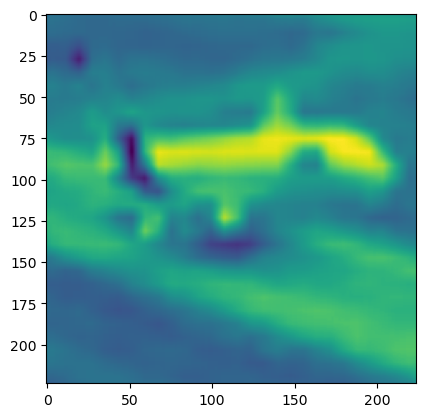

In [16]:
plt.imshow(proper_data[0][0])

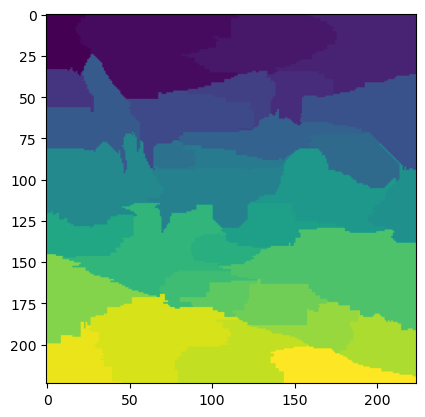

In [17]:
plt.imshow(proper_masks[0][0])

In [18]:
proper_masks = torch.stack(proper_masks)

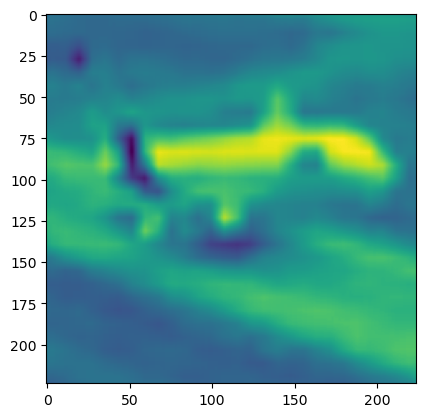

In [19]:
plt.imshow(proper_data[0][0])

In [21]:
torch.save(proper_masks, "CIFAR10/proper_masks.pt")

### Attributions (default parameters)

In [43]:
# Load tensors
proper_data = torch.load("CIFAR10/proper_data.pt").cuda()
preds = torch.load("CIFAR10/preds.pt").cuda()
proper_masks = torch.load("CIFAR10/proper_masks.pt").cuda()

In [23]:
def get_attributions(explainer, num_batches = 50):
    attributions = None
    for i in range(num_batches):
        batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
        if attributions is None:
            attributions = explainer.attribute(proper_data[batch_slice], target=preds[batch_slice])
        else:
            temp = explainer.attribute(proper_data[batch_slice], target=preds[batch_slice])
            attributions = torch.cat((attributions, temp), dim = 0)
    return attributions

In [24]:
model_cuda = model.cuda()

In [25]:
%%time
integrated_gradients = IntegratedGradients(model_cuda)
attributions_ig = get_attributions(integrated_gradients)
torch.save(attributions_ig, "CIFAR10/attributions_ig.pt")

CPU times: total: 1.34 s
Wall time: 4.61 s


In [26]:
%%time
saliency = Saliency(model_cuda)
attributions_s = get_attributions(saliency)
torch.save(attributions_s, "CIFAR10/attributions_s.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


CPU times: total: 93.8 ms
Wall time: 402 ms


In [27]:
num_batches = 50

In [28]:
%%time
gradient_shap = GradientShap(model_cuda)
attributions_gs = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_gs is None:
        attributions_gs = gradient_shap.attribute(proper_data[batch_slice].cuda(), torch.zeros_like(proper_data[0:1]), target=preds[batch_slice].cuda())
    else:
        temp = gradient_shap.attribute(proper_data[batch_slice].cuda(), torch.zeros_like(proper_data[0:1]), target=preds[batch_slice].cuda())
        attributions_gs = torch.cat((attributions_gs, temp), dim = 0)

torch.save(attributions_gs, "CIFAR10/attributions_gs.pt")

CPU times: total: 188 ms
Wall time: 747 ms


In [29]:
%%time
guided_backprop = GuidedBackprop(model_cuda)
attributions_gb = get_attributions(guided_backprop)
torch.save(attributions_gb, "CIFAR10/attributions_gb.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


CPU times: total: 46.9 ms
Wall time: 430 ms


In [30]:
%%time
deconvolution = Deconvolution(model_cuda)
attributions_d = get_attributions(deconvolution)
torch.save(attributions_d, "CIFAR10/attributions_d.pt")

CPU times: total: 46.9 ms
Wall time: 417 ms


In [31]:
%%time
input_x_gradient = InputXGradient(model_cuda)
attributions_ixg = get_attributions(input_x_gradient)
torch.save(attributions_ixg, "CIFAR10/attributions_ixg.pt")

CPU times: total: 62.5 ms
Wall time: 348 ms


In [32]:
%%time
# Need feature mask
lime = Lime(model_cuda)
attributions_l = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_l is None:
        attributions_l = lime.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = lime.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_l = torch.cat((attributions_l, temp), dim = 0)

torch.save(attributions_l, "CIFAR10/attributions_l.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to com

CPU times: total: 609 ms
Wall time: 7.86 s


In [33]:
%%time
occulsion = Occlusion(model_cuda)
attributions_o = None

# Using sliding window size (3, 15, 15) and strides = (3, 8, 8) as used in EnsembleXAI
for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_o is None:
        attributions_o = occulsion.attribute(proper_data[batch_slice].cuda(), (3, 15, 15), target=preds[batch_slice].cuda(), strides = (3, 8, 8))
    else:
        temp = occulsion.attribute(proper_data[batch_slice].cuda(), (3, 15, 15), target=preds[batch_slice].cuda(), strides = (3, 8, 8))
        attributions_o = torch.cat((attributions_o, temp), dim = 0)

torch.save(attributions_o, "CIFAR10/attributions_o.pt")

CPU times: total: 12.3 s
Wall time: 1min 41s


In [34]:
%%time
# Need feature mask
shapley_value_sampling = ShapleyValueSampling(model_cuda)
attributions_svs = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_svs is None:
        attributions_svs = shapley_value_sampling.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = shapley_value_sampling.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_svs = torch.cat((attributions_svs, temp), dim = 0)

torch.save(attributions_svs, "CIFAR10/attributions_svs.pt")

CPU times: total: 12.3 s
Wall time: 2min 13s


In [35]:
%%time
# Need feature mask
feature_ablation = FeatureAblation(model_cuda)
attributions_fa = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_fa is None:
        attributions_fa = feature_ablation.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = feature_ablation.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_fa = torch.cat((attributions_fa, temp), dim = 0)

torch.save(attributions_fa, "CIFAR10/attributions_fa.pt")

CPU times: total: 703 ms
Wall time: 5.64 s


In [36]:
%%time
# Need feature mask
kernel_shap = KernelShap(model_cuda)
attributions_ks = None

for i in range(num_batches):
    batch_slice = slice(i * len(proper_data) // num_batches, (i + 1) * len(proper_data) // num_batches)
    if attributions_ks is None:
        attributions_ks = kernel_shap.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
    else:
        temp = kernel_shap.attribute(proper_data[batch_slice], target=preds[batch_slice], feature_mask=proper_masks[batch_slice])
        attributions_ks = torch.cat((attributions_ks, temp), dim = 0)

torch.save(attributions_ks, "CIFAR10/attributions_ks.pt")

c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
c:\Users\jebcu\anaconda3\envs\cs471_project\Lib\site-packages\captum\attr\_core\lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to com

CPU times: total: 750 ms
Wall time: 7.94 s


In [37]:
%%time
noise_tunnel = NoiseTunnel(integrated_gradients) # base on EnsembleXAI
attributions_nt = get_attributions(noise_tunnel, num_batches = 100)
torch.save(attributions_nt, "CIFAR10/attributions_nt.pt")

CPU times: total: 4.33 s
Wall time: 20.4 s


### Normalization

In [38]:
from EnsembleXAI.Normalization import mean_var_normalize

In [39]:
attributions = {
    'attributions_ig': torch.load('CIFAR10/attributions_ig.pt'),
    'attributions_s': torch.load('CIFAR10/attributions_s.pt'),
    'attributions_gs': torch.load('CIFAR10/attributions_gs.pt'),
    'attributions_gb': torch.load('CIFAR10/attributions_gb.pt'),
    'attributions_d': torch.load('CIFAR10/attributions_d.pt'),
    'attributions_ixg': torch.load('CIFAR10/attributions_ixg.pt'),
    'attributions_l': torch.load('CIFAR10/attributions_l.pt'),
    'attributions_o': torch.load('CIFAR10/attributions_o.pt'),
    'attributions_svs': torch.load('CIFAR10/attributions_svs.pt'),
    'attributions_fa': torch.load('CIFAR10/attributions_fa.pt'),
    'attributions_ks': torch.load('CIFAR10/attributions_ks.pt'),
    'attributions_nt': torch.load('CIFAR10/attributions_nt.pt'),
}

In [40]:
normalized_attributions = {attr: mean_var_normalize(attributions[attr]) for attr in attributions}

### EnsembleXAI

In [41]:
from EnsembleXAI.Ensemble import normEnsembleXAI

In [42]:
explanations = torch.stack([normalized_attributions[attr] for attr in normalized_attributions], dim=1)

In [43]:
agg = normEnsembleXAI(explanations.detach(), aggregating_func='avg')

In [44]:
torch.save(agg, "CIFAR10/agg.pt")

### Ground truth masks

From https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html

In [18]:
import matplotlib.pyplot as plt

In [6]:
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights

weights = FCN_ResNet101_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet101(weights=weights, progress=False).cuda()
model = model.eval()

output = model(proper_data)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([100, 21, 224, 224]) -5.494383811950684 13.246280670166016


In [7]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

masks = [
    [normalized_masks[img_idx, sem_class_to_idx[cls]]
    for cls in sem_class_to_idx]
    for img_idx in range(len(proper_data))  
]

In [8]:
sem_class_to_idx.keys()

dict_keys(['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

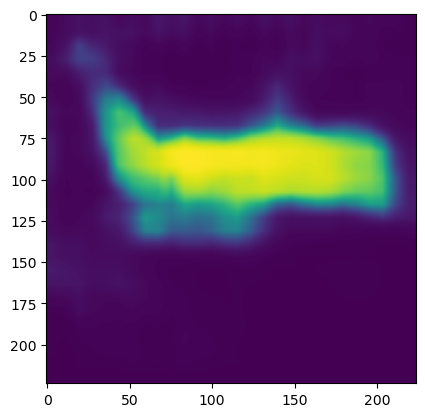

In [9]:
plt.imshow(masks[0][1].cpu().detach().numpy())

In [10]:
class_dim = 1
boolean_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['aeroplane'])

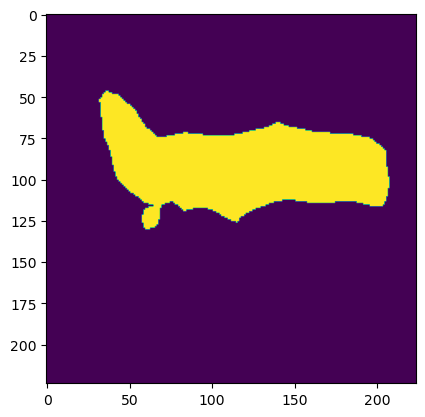

In [12]:
plt.imshow(boolean_masks[0].cpu().detach().numpy())

In [14]:
class_dim = 1
for i in range(len(masks)):
    if i // 10 == 0: # airplane -> aeroplane
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['aeroplane'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/airplane-{i % 10}.pt")
    elif i // 10 == 1: #'automobile' -> 'car'
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['car'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/automobile-{i % 10}.pt")
    elif i // 10 == 2: # bird
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['bird'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/bird-{i % 10}.pt")
    elif i // 10 == 3: # cat
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/cat-{i % 10}.pt")
    elif i // 10 == 5: # dog
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/dog-{i % 10}.pt")
    elif i // 10 == 7: # horse
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['horse'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/horse-{i % 10}.pt")
    elif i // 10 == 8: # 'ship' -> boat
        boolean_mask = (normalized_masks.argmax(class_dim) == sem_class_to_idx['boat'])[i]
        torch.save(boolean_mask, f"CIFAR10/masks/ship-{i % 10}.pt")

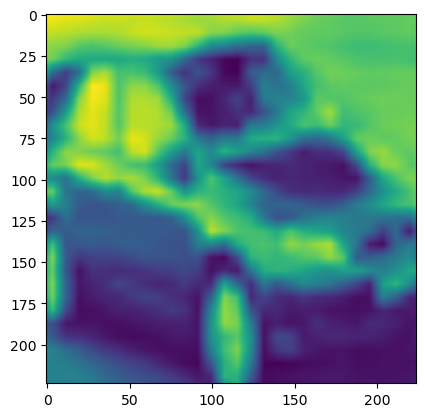

In [17]:
plt.imshow(proper_data[10][0].cpu().detach().numpy())

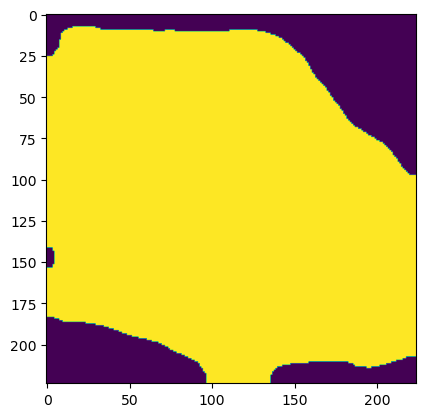

In [16]:
plt.imshow(torch.load("CIFAR10/masks/automobile-0.pt").cpu().detach().numpy())

- 'airplane' -> 'aeroplane'
- 'automobile' -> 'car'
- 'bird'
- 'cat'
- 'dog'
- 'horse'
- 'ship' -> boat

0 'airplane',
1 'automobile',
2 'bird',
3 'cat',
4 'deer',
5 'dog',
6 'frog',
7 'horse',
8 'ship',
9 'truck'

To get the masks for truck

In [23]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d).cuda() for d in all_images_original[-10:]]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False).cuda()
model = model.eval()

output = model(images)

In [26]:
for i in range(len(output)):
    output1 = output[i]
    masks1 = output1['masks']
    proba_threshold = 0.5
    bool_masks1 = output1['masks'] > proba_threshold

    # There's an extra dimension (1) to the masks. We need to remove it
    bool_masks = bool_masks1.squeeze(1)

    try:
        truck_index = [weights.meta["categories"][label] for label in output1['labels']].index("truck")
        truck_mask = bool_masks[truck_index]
    except:
        print (i)
        continue
    transformed_mask = resnet_transform(torch.stack([truck_mask]*3))

    temp = transformed_mask[0].cpu()
    values = temp.unique().tolist()
    temp.apply_(lambda val: values.index(val))
    temp_int = temp.int()
    torch.save(temp_int, f"CIFAR10/masks/truck-{i}.pt")

2
6
9


No deer, frog

Hand made masks for deer and frog

In [19]:
import numpy as np

In [55]:
mask = torch.tensor(np.load(f"CIFAR10/masks/deer-{i}.npy")*255)
transformed_mask = resnet_transform(torch.stack([mask]*3))

In [58]:
for i in range(10):
    mask = torch.tensor(np.load(f"CIFAR10/masks/deer-{i}.npy")*255)
    transformed_mask = resnet_transform(torch.stack([mask]*3))

    temp = transformed_mask[0].cpu()
    values = temp.unique().tolist()
    temp.apply_(lambda val: 0 != values.index(val))
    temp_int = temp.int()
    torch.save(temp_int, f"CIFAR10/masks/deer-{i}.pt")

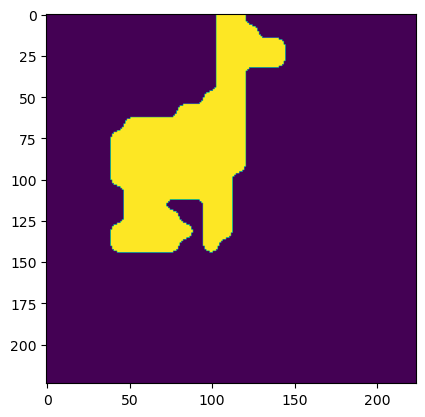

In [69]:
plt.imshow(torch.load("CIFAR10/masks/deer-9.pt").detach().numpy())

In [70]:
for i in range(10):
    mask = torch.tensor(np.load(f"CIFAR10/masks/frog-{i}.npy")*255)
    transformed_mask = resnet_transform(torch.stack([mask]*3))

    temp = transformed_mask[0].cpu()
    values = temp.unique().tolist()
    temp.apply_(lambda val: 0 != values.index(val))
    temp_int = temp.int()
    torch.save(temp_int, f"CIFAR10/masks/frog-{i}.pt")

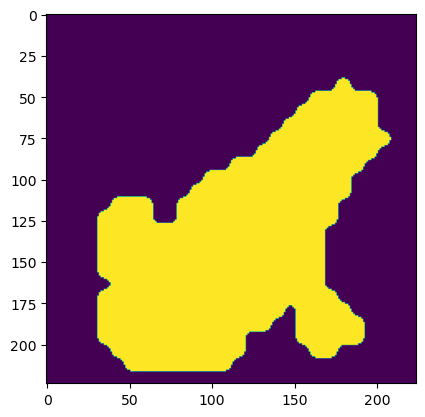

In [80]:
plt.imshow(torch.load("CIFAR10/masks/frog-9.pt").detach().numpy())

In [87]:
i = 6
mask = torch.tensor(np.load(f"CIFAR10/masks/truck-{i}.npy")*255)
transformed_mask = resnet_transform(torch.stack([mask]*3))

temp = transformed_mask[0].cpu()
values = temp.unique().tolist()
temp.apply_(lambda val: 0 != values.index(val))
temp_int = temp.int()
torch.save(temp_int, f"CIFAR10/masks/truck-{i}.pt")

In [105]:
arr = np.array(Image.open("CIFAR10/data/truck-9.png"))
arr = arr.transpose(2,0,1)
arr = arr.sum(axis = 0)

In [115]:
mask = torch.tensor((arr < 715)*255)
transformed_mask = resnet_transform(torch.stack([mask]*3))

temp = transformed_mask[0].cpu()
values = temp.unique().tolist()
temp.apply_(lambda val: 0 != values.index(val))
temp_int = temp.int()
torch.save(temp_int, f"CIFAR10/masks/truck-9.pt")

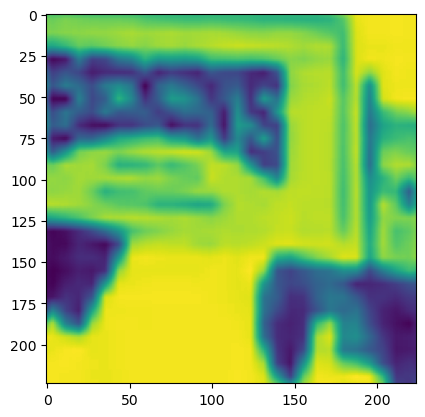

In [119]:
plt.imshow(proper_data[-1][0].cpu().detach().numpy())

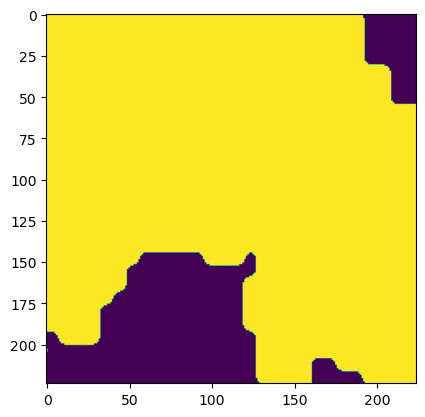

In [116]:
plt.imshow(torch.load("CIFAR10/masks/truck-9.pt").detach().numpy())

### For the empty masks from semantic segmentation

tensor([[ 5],
        [ 6],
        [ 8],
        [20],
        [22],
        [28],
        [30],
        [32],
        [35],
        [36],
        [38],
        [56],
        [58],
        [80],
        [83],
        [84],
        [87],
        [88]]) -> empty

torch.Size([100, 21, 224, 224]) -5.494383811950684 13.246280670166016


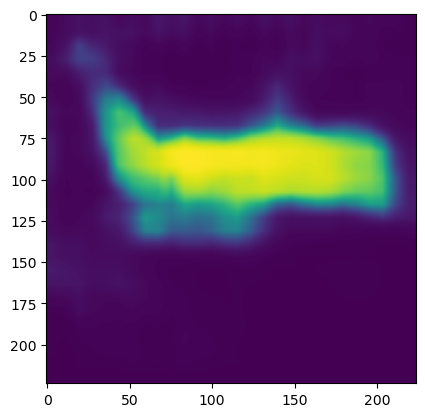

In [44]:
import matplotlib.pyplot as plt

from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights

weights = FCN_ResNet101_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet101(weights=weights, progress=False).cuda()
model = model.eval()

output = model(proper_data)['out']
print(output.shape, output.min().item(), output.max().item())

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

masks = [
    [normalized_masks[img_idx, sem_class_to_idx[cls]]
    for cls in sem_class_to_idx]
    for img_idx in range(len(proper_data))  
]

sem_class_to_idx.keys()

plt.imshow(masks[0][1].cpu().detach().numpy())

In [152]:
class_dim = 1
for i in [5, 6, 8, 20, 22, 28, 30, 32, 35, 36, 38, 56, 58, 80, 83, 84, 87, 88]:
    boolean_mask = ~torch.gt(masks[i][0], 0.9)
    if i // 10 == 0: # airplane -> aeroplane
        torch.save(boolean_mask, f"CIFAR10/masks/airplane-{i % 10}.pt")
    elif i // 10 == 1: #'automobile' -> 'car'
        torch.save(boolean_mask, f"CIFAR10/masks/automobile-{i % 10}.pt")
    elif i // 10 == 2: # bird
        torch.save(boolean_mask, f"CIFAR10/masks/bird-{i % 10}.pt")
    elif i // 10 == 3: # cat
        torch.save(boolean_mask, f"CIFAR10/masks/cat-{i % 10}.pt")
    elif i // 10 == 5: # dog
        torch.save(boolean_mask, f"CIFAR10/masks/dog-{i % 10}.pt")
    elif i // 10 == 7: # horse
        torch.save(boolean_mask, f"CIFAR10/masks/horse-{i % 10}.pt")
    elif i // 10 == 8: # 'ship' -> boat
        torch.save(boolean_mask, f"CIFAR10/masks/ship-{i % 10}.pt")
    if boolean_mask.min().item():
        print(i)
    if not boolean_mask.max().item():
        print(f"Uh oh {i}")

30
38
80
84


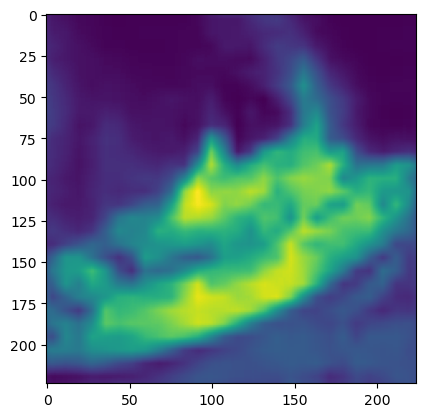

In [155]:
plt.imshow(proper_data[84].cpu().detach().numpy()[0])

Combine together to one tensor

In [40]:
torch.load("ImageNet/ground_truth_masks.pt").shape

torch.Size([500, 224, 224])

In [156]:
ground_truth_masks = None
for i in images:
    count = 0
    for img in images[i]:
        temp = torch.load(f"CIFAR10/masks/{trainset.classes[i]}-{count}.pt").cpu().unsqueeze(dim = 0)
        if ground_truth_masks is None:
            ground_truth_masks = temp
        else:
            ground_truth_masks = torch.cat((ground_truth_masks, temp), dim = 0)

        count += 1

In [157]:
torch.save(ground_truth_masks, "CIFAR10/ground_truth_masks.pt")